# 3D Partially coherent ODT forward simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fft2, ifft2, fftshift, ifftshift, fftn, ifftn

import pickle
import waveorder as wo

%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use(['dark_background']) # Plotting option for dark background


### Experiment parameters

In [2]:
N           = 256                 # number of pixel in y dimension
M           = 256                 # number of pixel in x dimension
L           = 100                 # number of layers in z dimension
n_media     = 1.46                # refractive index in the media
mag         = 63                  # magnification
ps          = 6.5/mag             # effective pixel size
psz         = 0.25                # axial pixel size
lambda_illu = 0.532               # wavelength
NA_obj      = 1.2                 # objective NA
NA_illu     = 0.9                 # illumination NA

### Sample creation

In [3]:
radius = 5
blur_size = 2*ps
sphere = wo.gen_sphere_target((N,M,L), ps, psz, radius, blur_size)
wo.image_stack_viewer(np.transpose(sphere,(2,0,1)))

interactive(children=(IntSlider(value=0, description='stack_idx', max=99), Output()), _dom_classes=('widget-in…

<function waveorder.visual.image_stack_viewer.<locals>.interact_plot_3D(stack_idx)>

In [4]:
# Physical value assignment

n_sample = 1.50 

RI_map = np.zeros_like(sphere)
RI_map[sphere > 0] = sphere[sphere > 0]*(n_sample-n_media)
RI_map += n_media
t_obj = np.exp(1j*2*np.pi*psz*(RI_map-n_media))


In [5]:
wo.image_stack_viewer(np.transpose(np.angle(t_obj),(2,0,1)))

interactive(children=(IntSlider(value=0, description='stack_idx', max=99), Output()), _dom_classes=('widget-in…

<function waveorder.visual.image_stack_viewer.<locals>.interact_plot_3D(stack_idx)>

### Setup acquisition

In [6]:
z_defocus = (np.r_[:L]-L//2)*psz
chi = 0.1*2*np.pi
setup = wo.waveorder_microscopy((N,M), lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi, \
                                n_media = n_media, phase_deconv='3D')

simulator = wo.waveorder_microscopy_simulator((N,M), lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi, \
                                n_media = n_media)


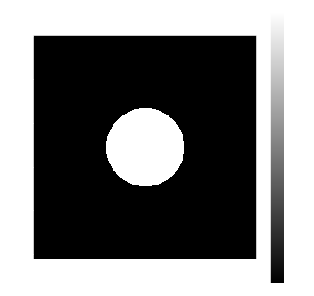

In [7]:
plt.figure(figsize=(5,5))
plt.imshow(fftshift(setup.Source), cmap='gray')
plt.colorbar()

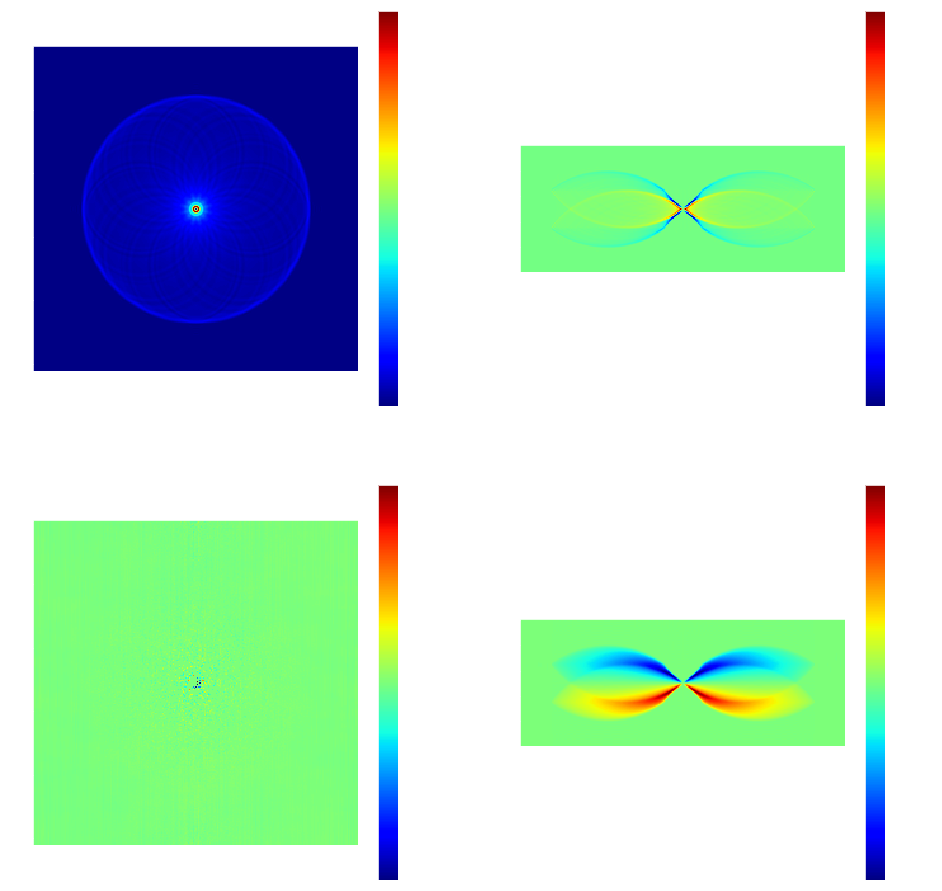

In [8]:
H_re_vis = fftshift(setup.H_re)

wo.plot_multicolumn([np.real(H_re_vis)[:,:,L//2], np.transpose(np.real(H_re_vis)[N//2,:,:]), \
                     np.imag(H_re_vis)[:,:,L//2], np.transpose(np.imag(H_re_vis)[N//2,:,:])], \
                    num_col=2, size=8, set_title=True, \
                    titles=['$xy$-slice of Re{$H_{re}$} at $u_z=0$', '$xz$-slice of Re{$H_{re}$} at $u_y=0$', \
                            '$xy$-slice of Im{$H_{re}$} at $u_z=0$', '$xz$-slice of Im{$H_{re}$} at $u_y=0$'], colormap='jet')

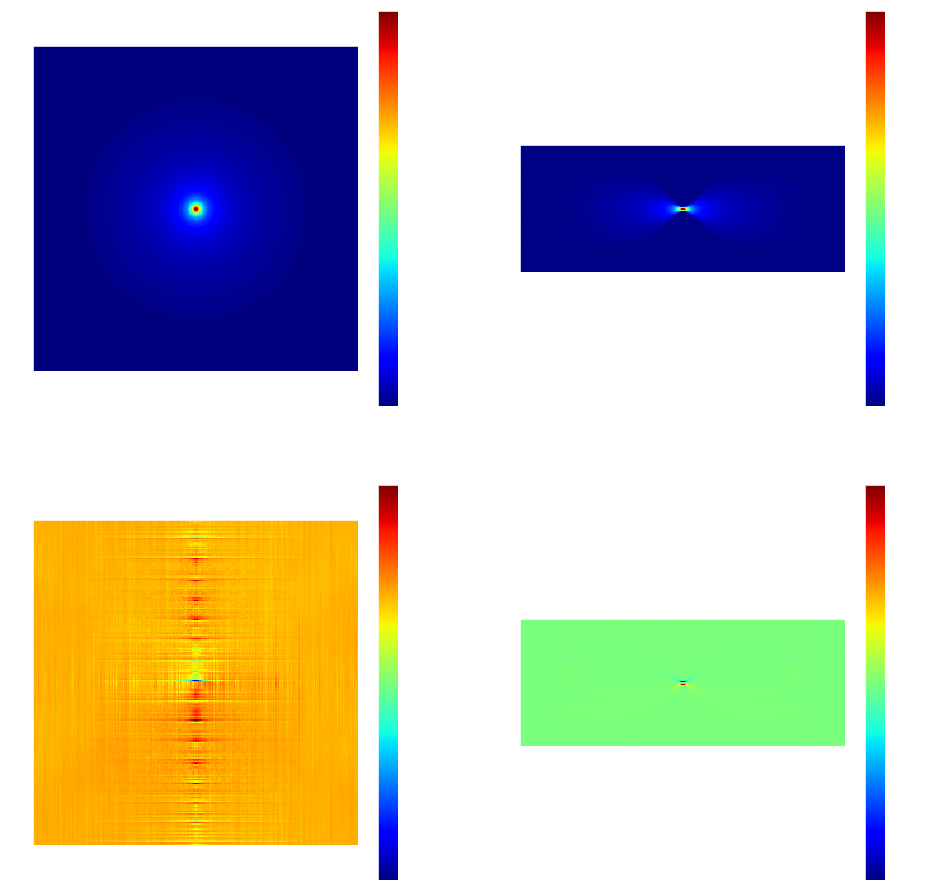

In [9]:
H_im_vis = fftshift(setup.H_im)

wo.plot_multicolumn([np.real(H_im_vis)[:,:,L//2], np.transpose(np.real(H_im_vis)[N//2,:,:]), \
                     np.imag(H_im_vis)[:,:,L//2], np.transpose(np.imag(H_im_vis)[N//2,:,:])], \
                    num_col=2, size=8, set_title=True, \
                    titles=['$xy$-slice of Re{$H_{im}$} at $u_z=0$', '$xz$-slice of Re{$H_{im}$} at $u_y=0$', \
                            '$xy$-slice of Im{$H_{im}$} at $u_z=0$', '$xz$-slice of Im{$H_{im}$} at $u_y=0$'], colormap='jet')

In [10]:
I_meas = simulator.simulate_3D_scalar_measurements(t_obj)

Number of point sources considered (100 / 6269) in pattern (1 / 1), elapsed time: 38.23
Number of point sources considered (200 / 6269) in pattern (1 / 1), elapsed time: 76.88
Number of point sources considered (300 / 6269) in pattern (1 / 1), elapsed time: 117.49
Number of point sources considered (400 / 6269) in pattern (1 / 1), elapsed time: 158.36
Number of point sources considered (500 / 6269) in pattern (1 / 1), elapsed time: 200.64
Number of point sources considered (600 / 6269) in pattern (1 / 1), elapsed time: 241.54
Number of point sources considered (700 / 6269) in pattern (1 / 1), elapsed time: 281.66
Number of point sources considered (800 / 6269) in pattern (1 / 1), elapsed time: 312.83
Number of point sources considered (900 / 6269) in pattern (1 / 1), elapsed time: 339.50
Number of point sources considered (1000 / 6269) in pattern (1 / 1), elapsed time: 367.53
Number of point sources considered (1100 / 6269) in pattern (1 / 1), elapsed time: 394.63
Number of point sourc

In [12]:
wo.image_stack_viewer(np.transpose(np.abs(I_meas),(0,1,2)))

interactive(children=(IntSlider(value=0, description='stack_idx', max=255), Output()), _dom_classes=('widget-i…

<function waveorder.visual.image_stack_viewer.<locals>.interact_plot_3D(stack_idx)>

In [13]:
# Save simulations

f = open('simulation_data_PODT.pckl', 'wb')
pickle.dump((I_meas, lambda_illu, n_media, ps, psz, NA_obj, NA_illu), f)
f.close()